# 6. Linear Model Selection and Regularisation – Labs

Excercises from **Chapter 6** of [An Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/) by Gareth James, Daniela Witten, Trevor Hastie and Robert Tibshirani.

In [177]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import itertools
from IPython.display import display, HTML
from sklearn import linear_model
from sklearn.model_selection import KFold
from ipywidgets import interact
import ipywidgets as widgets
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load data
hitters_pd = pd.read_csv('./data/Hitters.csv')

# Drop 59 rows missing data
hitters_pd = hitters_pd.dropna()
assert hitters_pd.isna().sum().sum() == 0

# Create dummy variables for qualitative features
qual = ['League', 'Division', 'NewLeague']
hitters_pd = pd.get_dummies(hitters_pd, columns=qual)

hitters_pd.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,...,PutOuts,Assists,Errors,Salary,League_A,League_N,Division_E,Division_W,NewLeague_A,NewLeague_N
1,315,81,7,24,38,39,14,3449,835,69,...,632,43,10,475.0,0,1,0,1,0,1
2,479,130,18,66,72,76,3,1624,457,63,...,880,82,14,480.0,1,0,0,1,1,0
3,496,141,20,65,78,37,11,5628,1575,225,...,200,11,3,500.0,0,1,1,0,0,1
4,321,87,10,39,42,30,2,396,101,12,...,805,40,4,91.5,0,1,1,0,0,1
5,594,169,4,74,51,35,11,4408,1133,19,...,282,421,25,750.0,1,0,0,1,1,0


## Lab 1: Subset Selection Methods

### 6.5.1 Best subset selection

Perform best subset selection by identifying the best model that contains a given number of predictors, where best is quantified using RSS.

In [3]:
def get_models(k, X, y):
    """
    Fit all possible models that contain exactly k predictors.
    """
    # List all available predictors
    X_combos = itertools.combinations(list(X.columns), k)
    
    # Fit all models accumulating Residual Sum of Squares (RSS)
    models = []
    for X_label in X_combos:
        # Parse patsy formula
        X_smf = ' + '.join(X_label)
        f     = 'Salary ~ {}'.format(X_smf)
        # Fit model
        model = smf.ols(formula=f, data=pd.concat([X, y], axis=1)).fit()
        # Return results
        models += [(f, model)]
    return models


def min_rss(statsmodels):
    """Return model with lowest Residual Sum of Squares (RSS)"""
    return sorted(statsmodels, key=lambda tup: tup[1].ssr)[0]


def max_adjr2(statsmodels):
    """Return model with lowest R-squared"""
    return sorted(statsmodels, reverse=True, key=lambda tup: tup[1].rsquared_adj)[0]


### Which model with 2 predictors yields lowest RSS score?

In [4]:
X = hitters_pd.drop('Salary', axis=1)
y = hitters_pd['Salary']

# Set number ofr predictors in subset
k = 2

# Get all possible models in subset
subset = get_models(2, X, y)

# Display results
print('This model yields the lowest RSS score for the subset of models with {} predictors:'.format(k))
display(min_rss(subset))

print('This model yields the highest adjusted R-squared score for the subset of models with {} predictors:'.format(k))
max_adjr2(get_models(2, X, y))

This model yields the lowest RSS score for the subset of models with 2 predictors:


('Salary ~ Hits + CRBI',
 <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x1c21bf36d8>)

This model yields the highest adjusted R-squared score for the subset of models with 2 predictors:


('Salary ~ Hits + CRBI',
 <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x1c22224c50>)

In [5]:
X.columns

Index(['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat',
       'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'PutOuts', 'Assists',
       'Errors', 'League_A', 'League_N', 'Division_E', 'Division_W',
       'NewLeague_A', 'NewLeague_N'],
      dtype='object')

The model with 2 predictors that yields the lowest RSS score is the one that uses the predictors 'Hits', and 'CRBI'

### How do the the maximum $R^2$, minimum RSS, and BIC statistics vary for each subset with k predictors? 

First we fit all possible models in each subset of models with k predictors. This turns out to be a very computationally expensive process, running on my laptop for 30 minutes yielded results up to only k=6 and occupied 30GB of memeory. Not suprising as number of possible combinations without repetition is given by:

$\frac{p!}{k!(p-k)!}$

Where *p* is number of predictors to choose from and we choose *k* of them.

In this example p=22, there are 22 predictors.

For k = 4 the number of possible combinations is given by:

$\frac{22!}{4!x 18!} = 74,613$

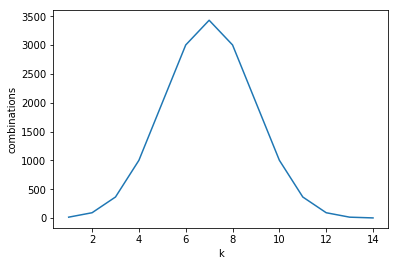

In [6]:
# How does the number of possible combinations of the 22 features vary with k?
# Lets do a quick plot to find out!

from scipy.special import factorial

n = 14
k = np.arange(1, n+1)
y = factorial(n) / (factorial(k)*factorial(n-k))

ax = sns.lineplot(x=k, y=y)
plt.xlabel('k')
plt.ylabel('combinations');

The plot above shows that there up to ~700,000 possible combinations of the predictors without repetition for some values of k when p = 22/

The ISL authors provide comparison of the $R^2$ statistic for all combinations of 19 predictors. When p=19 the max number of combinations for any given subset is reduced by 10x, when p=10 the max combinations is reduced by ~2000x. 

My current machine maxed out its memory trying to compute all models for p=22. I'll try p=14 by picking 14 of the predictors for brevity. 



In [7]:
# Pick arbitrary subset of predictors to save compute/memory
X = hitters_pd.loc[:, 'AtBat':'PutOuts']
y = hitters_pd['Salary']

# get all model results
model_subsets = []
for k in range(len(X.columns)):
    k=k+1
    subset = get_models(k, X, y)
    model_subsets += [subset]
    print('Progess: k = {}, done'.format(k))

Progess: k = 1, done
Progess: k = 2, done
Progess: k = 3, done
Progess: k = 4, done
Progess: k = 5, done
Progess: k = 6, done
Progess: k = 7, done
Progess: k = 8, done
Progess: k = 9, done
Progess: k = 10, done
Progess: k = 11, done
Progess: k = 12, done
Progess: k = 13, done
Progess: k = 14, done


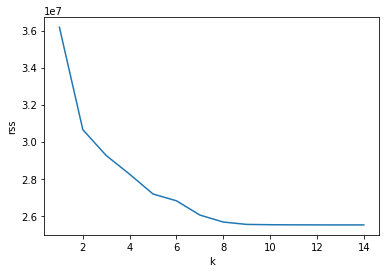

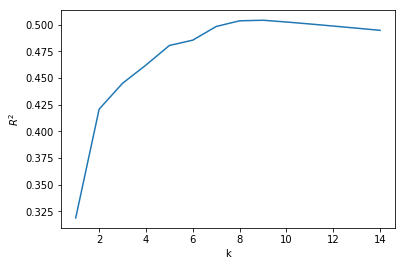

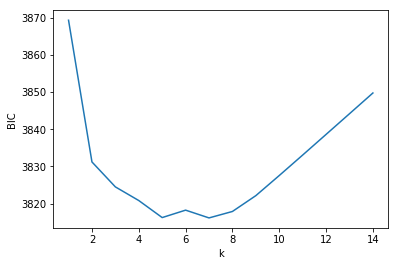

In [8]:
# Get best rss score for each subset
rss   = [min_rss(m)[1].ssr for m in model_subsets]

# Get best r-squared score for each subset
adjr2 = [max_adjr2(m)[1].rsquared_adj for m in model_subsets]
k     = np.arange(1, len(rss)+1)


# Get best BIC
def min_bic(statsmodels):
    """Return model with lowest R-squared"""
    return sorted(statsmodels, reverse=False, key=lambda tup: tup[1].bic)[0]

bic = [min_bic(m)[1].bic for m in model_subsets]


ax = sns.lineplot(x=k, y=rss)
plt.xlabel('k')
plt.ylabel('rss')
plt.show()

sns.lineplot(x=k, y=adjr2)
plt.xlabel('k')
plt.ylabel('$R^2$')
plt.show()

sns.lineplot(x=k, y=bic)
plt.xlabel('k')
plt.ylabel('BIC')
plt.show()

The stats above seem to confer that a model with around 8 predictors is best. But has each method chosen the same or similar models?

In [9]:
best_subset_6 = list(min_rss(model_subsets[5])[1].params.index)[1:]
print(best_subset_6)

['AtBat', 'Hits', 'Walks', 'CRuns', 'CWalks', 'PutOuts']


In [10]:
list(max_adjr2(model_subsets[5])[1].params.index)[1:]

['AtBat', 'Hits', 'Walks', 'CRuns', 'CWalks', 'PutOuts']

In [11]:
list(min_bic(model_subsets[5])[1].params.index)[1:]

['AtBat', 'Hits', 'Walks', 'CRuns', 'CWalks', 'PutOuts']

All three statisticis yield the same model for the subset with 6 predictors. This is expected for RSS and R-squared stats because they are related.

### 6.5.2 Forward and Backward Stepwise Selection

In [12]:
def scale(df):
    """Xi = Xi - mu(Xi) / σ(Xi)"""
    return (df-df.mean())/(df.std())


def forward_stepwise(X, y, results=[(0, [])]):
    """Perform forward stepwise variable selection as described in
    An Introductions to Statistical Learning (p.207)
    Returns pandas dataframe object  with results for each step"""
    # List predictors that havent's been used so far
    p_all    = list(X.columns)
    p_used   = results[-1][1]
    p_unused = [p for p in p_all if p not in p_used]
    
    # Job done, exit recursion
    if not p_unused:
        rss   = [r[0] for r in results]
        preds = [r[1] for r in results]
        return pd.DataFrame({'rss': rss, 'predictors': preds}).drop(0).reset_index()
    
    # Get rss score for each possible additional predictor
    r = []
    for p in p_unused:
        f     = 'Salary ~ {}'.format('+'.join([p]+p_used))
        # Fit model
        model = smf.ols(formula=f, data=pd.concat([X, y], axis=1)).fit()
        r     += [(model.ssr, [p]+p_used)]
    
    # Choose predictor which yields lowest rss
    min_rss     = sorted(r, key=lambda tup: tup[0])[0]   
    new_results = results + [min_rss]
    # Recursive call to self
    return forward_stepwise(X, y, new_results)


def backward_stepwise(X, y, results=[]):
    """Perform backward stepwise variable selection as described in
    An Introductions to Statistical Learning (p.209)
    Returns pandas dataframe object  with results for each step"""
    # List predictors that havent's been used so far
    p_all    = list(X.columns)

    # Check if we're starting out here
    if not results:
        # Fit model with all features
        f     = 'Salary ~ {}'.format('+'.join(p_all))
        model = smf.ols(formula=f, data=pd.concat([X, y], axis=1)).fit()
        # Begin backward stepwise recursion
        return backward_stepwise(X, y, [(model.ssr, p_all)])
    else:
        p_used = results[-1][1]
    
    # Job done, exit recursion
    if len(p_used) == 1:
        rss   = [r[0] for r in results]
        preds = [r[1] for r in results]
        return pd.DataFrame({'rss': rss, 'predictors': preds})    
    
    # Get rss score for each possible removed predictor
    r = []
    for p in p_used:
        p_test = [i for i in p_used if i != p]
        f     = 'Salary ~ {}'.format('+'.join(p_test))
        # Fit model
        model = smf.ols(formula=f, data=pd.concat([X, y], axis=1)).fit()
        r     += [(model.ssr, p_test)]
    
    # Choose removal of predictor which yields lowest rss
    min_rss     = sorted(r, key=lambda tup: tup[0])[0]   
    new_results = results + [min_rss]
    return backward_stepwise(X, y, new_results)

In [13]:
X = scale(hitters_pd.loc[:, 'AtBat':'PutOuts'])
y = hitters_pd['Salary']

forward_stepwise_results = forward_stepwise(X, y)
display(HTML('<h4>Forward Stepwise Selection</h4>'))
display(forward_stepwise_results)

backward_stepwise_results = backward_stepwise(X, y)
display(HTML('<h4>Backward Stepwise Selection</h4>'))
display(backward_stepwise_results)

,index,rss,predictors
0,1,3.617968e+07,[CRBI]
1,2,3.064656e+07,"[Hits, CRBI]"
2,3,2.924930e+07,"[PutOuts, Hits, CRBI]"
3,4,2.823936e+07,"[AtBat, PutOuts, Hits, CRBI]"
4,5,2.717042e+07,"[Walks, AtBat, PutOuts, Hits, CRBI]"
5,6,2.699220e+07,"[CWalks, Walks, AtBat, PutOuts, Hits, CRBI]"
6,7,2.614246e+07,"[CRuns, CWalks, Walks, AtBat, PutOuts, Hits, C..."
7,8,2.565678e+07,"[CAtBat, CRuns, CWalks, Walks, AtBat, PutOuts,..."
8,9,2.552857e+07,"[Runs, CAtBat, CRuns, CWalks, Walks, AtBat, Pu..."
9,10,2.551233e+07,"[Years, Runs, CAtBat, CRuns, CWalks, Walks, At..."


,rss,predictors
0,2.550169e+07,"[AtBat, Hits, HmRun, Runs, RBI, Walks, Years, ..."
1,2.550170e+07,"[AtBat, Hits, HmRun, Runs, Walks, Years, CAtBa..."
2,2.550319e+07,"[AtBat, Hits, Runs, Walks, Years, CAtBat, CHit..."
3,2.550552e+07,"[AtBat, Hits, Runs, Walks, Years, CAtBat, CHmR..."
4,2.551233e+07,"[AtBat, Hits, Runs, Walks, Years, CAtBat, CRun..."
5,2.552857e+07,"[AtBat, Hits, Runs, Walks, CAtBat, CRuns, CRBI..."
6,2.565678e+07,"[AtBat, Hits, Walks, CAtBat, CRuns, CRBI, CWal..."
7,2.614246e+07,"[AtBat, Hits, Walks, CRuns, CRBI, CWalks, PutO..."
8,2.680370e+07,"[AtBat, Hits, Walks, CRuns, CWalks, PutOuts]"
9,2.750952e+07,"[AtBat, Hits, Walks, CRuns, PutOuts]"


In [14]:
display(HTML('<h4>Comparison of methods for subset with 6 predictors</h4>'))
print('Best Subset Selection       : {}'.format(sorted(best_subset_6)))
print('Forward Stepwise Selection  : {}'.format(sorted(forward_stepwise_results.loc[5]['predictors'])))
print('Backward Stepwise Selection : {}'.format(sorted(backward_stepwise_results.loc[8]['predictors'])))

Best Subset Selection       : ['AtBat', 'CRuns', 'CWalks', 'Hits', 'PutOuts', 'Walks']
Forward Stepwise Selection  : ['AtBat', 'CRBI', 'CWalks', 'Hits', 'PutOuts', 'Walks']
Backward Stepwise Selection : ['AtBat', 'CRuns', 'CWalks', 'Hits', 'PutOuts', 'Walks']


The above results show that Backward Stepwise Selection chooses the same 6 predictors as Best Subset Selection. Forward Stepwise Selection chooses all but one of the same predictors.

Backward Stepwise Selection therefore looks like the best approach as it makes the same optimal selection as best subset selection, but with significantly lower computational cost.

### 6.5.3 Choosing Among Models Using the Validation Set Approach and Cross-Validation

In [15]:
def best_subset_rss(X, y):
    """Perform best subset selection using Residual Sum of Squares to
    select best model in each subset.
    Notes: highly computationally expensive for large number of features in  X
    Maxes out my laptop for p > 14"""
    # get all model results
    model_subsets = []
    for k in range(len(X.columns)):
        k=k+1
        subset = get_models(k, X, y)
        model_subsets += [subset]
        print('Best subset selected: k = {}/{}, done'.format(k, len(X.columns)))
    # Get best rss score for each subset
    return [min_rss(m) for m in model_subsets]

def mse(y_hat, y):
    """Calculate Mean Squared Error"""
    return np.sum(np.square(y_hat - y)) / y.size

In [16]:
# Create index for 50% holdout set
np.random.seed(1)
train = np.random.rand(len(hitters_pd)) < 0.5

response   = 'Salary'

# Assign train and test sets
X_train = hitters_pd[train].loc[:, 'AtBat':'PutOuts']
X_test  = hitters_pd[~train].loc[:, 'AtBat':'PutOuts']
y_train = hitters_pd[train][response]
y_test  = hitters_pd[~train][response]

# Perform best_subset selection
best_subsets = best_subset_rss(X_train, y_train)

Best subset selected: k = 1/14, done
Best subset selected: k = 2/14, done
Best subset selected: k = 3/14, done
Best subset selected: k = 4/14, done
Best subset selected: k = 5/14, done
Best subset selected: k = 6/14, done
Best subset selected: k = 7/14, done
Best subset selected: k = 8/14, done
Best subset selected: k = 9/14, done
Best subset selected: k = 10/14, done
Best subset selected: k = 11/14, done
Best subset selected: k = 12/14, done
Best subset selected: k = 13/14, done
Best subset selected: k = 14/14, done


,predictors,MSE
0,1,178139.358427
1,2,165215.400785
2,3,170773.977180
3,4,154020.720967
4,5,147281.971965
5,6,148387.589992
6,7,149105.946391
7,8,138481.274569
8,9,133463.544833
9,10,134906.763925


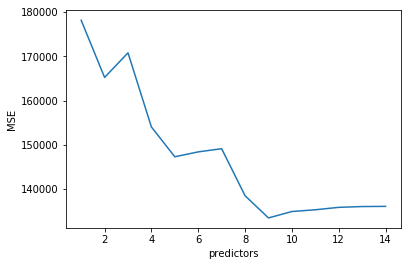

In [17]:
# Using 50% hold out set
# Measure mean squared error for each model selected by best subset selection
MSEs = []
for m in best_subsets:
    model = m[1]
    y_hat = model.predict(X_test)
    r     = mse(y_hat, y_test)
    MSEs += [r]

results = pd.DataFrame({'predictors': np.arange(1, 15), 'MSE': MSEs})
display(results)
sns.lineplot(x='predictors', y='MSE', data=results);

Above we performed best subset selection up to 14 predictors using the training set createad from a 50% hold-out set. We then use the test set to measure the MSE for the selected model in each subset of p predictors. 

We observe the lowest MSE for the model with 9 predictors.

In [18]:
# Which 9 predictors did best subset selection choose based on the TRAINING set?
best_subsets[8][0]

'Salary ~ AtBat + Hits + HmRun + Walks + CAtBat + CRuns + CRBI + CWalks + PutOuts'

In [19]:
# Which 9 predictors does best subset selection choose based on the FULL set?
best_subsets_full = best_subset_rss(hitters_pd.loc[:, 'AtBat':'PutOuts'], hitters_pd['Salary'])
best_subsets_full[8][0]

Best subset selected: k = 1/14, done
Best subset selected: k = 2/14, done
Best subset selected: k = 3/14, done
Best subset selected: k = 4/14, done
Best subset selected: k = 5/14, done
Best subset selected: k = 6/14, done
Best subset selected: k = 7/14, done
Best subset selected: k = 8/14, done
Best subset selected: k = 9/14, done
Best subset selected: k = 10/14, done
Best subset selected: k = 11/14, done
Best subset selected: k = 12/14, done
Best subset selected: k = 13/14, done
Best subset selected: k = 14/14, done


'Salary ~ AtBat + Hits + Runs + Walks + CAtBat + CRuns + CRBI + CWalks + PutOuts'

This time the same model is selected using the full dataset, as is selected using just the training set. This won't always be the case however, so the ISL authors reccomend taking the model that best subset selection chooses using the full dataset.

**Revision note:** My understanind of what the authors seem to be suggesting is:

- fit all possible models on training set
- choose best model in each subset by RSS
- use test MSE to choose best subset, e.g optimal number of predictors *p*
- fit all possible models with optimal value of p predictors on *full* dataset
- choose best model by RSS

This seems odd to me because the model finaly chosen has not been verified on the test set. If the actual predictors are to be chosen on the full set, why not pass this model through validation? Note that this does not mean the model fitted on full dataset is then used in test:

- fit all possible models on full dataset
- choose best combination of predictors in each subset by RSS
- use above choices to fit models on training set
- use test MSE to choose best subset
- model with lowest MSE is chosen

This approach also seems to simplify use of best subset selection with cross-validation:

- fit all possible models on full dataset
- choose best combination of predictors in each subset by RSS
- choose from above predictor subsets using cross validation

In [20]:
def cross_val(formula, X, y, k):
    """Perform k-fold cross validation to return mean MSE score
    Expects formula as Patsy formula"""
    # Split dataset into k-folds
    # Note: np.array_split doesn't raise excpetion is folds are unequal in size
    X_folds = np.array_split(X, k)
    y_folds = np.array_split(y, k)
    
    MSEs = []
    for f in np.arange(len(X_folds)):
        # Create training and test sets
        X_test  = X_folds[f]
        y_test  = y_folds[f]
        X_train = X.drop(X_folds[f].index)
        y_train = y.drop(y_folds[f].index)
        
        # Fit model
        model = smf.ols(formula=formula, data=pd.concat([X_train, y_train], axis=1)).fit()
        
        # Measure MSE
        y_hat = model.predict(X_test)
        MSEs += [mse(y_hat, y_test)]
    return (MSEs, formula)
    

In [21]:
# Get best subsets of predictors for full dataset
X = hitters_pd.loc[:, 'AtBat':'PutOuts']
y = hitters_pd['Salary']

best_subsets_full = best_subset_rss(X, y)

Best subset selected: k = 1/14, done
Best subset selected: k = 2/14, done
Best subset selected: k = 3/14, done
Best subset selected: k = 4/14, done
Best subset selected: k = 5/14, done
Best subset selected: k = 6/14, done
Best subset selected: k = 7/14, done
Best subset selected: k = 8/14, done
Best subset selected: k = 9/14, done
Best subset selected: k = 10/14, done
Best subset selected: k = 11/14, done
Best subset selected: k = 12/14, done
Best subset selected: k = 13/14, done
Best subset selected: k = 14/14, done


,predictors,MSE_mean,MSE_folds,Model
0,1,142840.888022,"[52976.57302399576, 80338.281999855, 282759.54...",Salary ~ CRBI
1,2,124466.240992,"[60439.110444577454, 44215.5427373037, 210423....",Salary ~ Hits + CRBI
2,3,119812.512799,"[71609.19418407278, 42531.326374113065, 189132...",Salary ~ Hits + CRBI + PutOuts
3,4,116723.518363,"[70957.22282838816, 45714.23594875619, 174585....",Salary ~ AtBat + Hits + CRBI + PutOuts
4,5,112340.754784,"[67046.46201253521, 43301.142890066694, 178826...",Salary ~ AtBat + Hits + Walks + CRBI + PutOuts
5,6,113132.633435,"[88211.72188654834, 36778.67067994044, 188866....",Salary ~ AtBat + Hits + Walks + CRuns + CWalks...
6,7,110827.847248,"[87533.41276121038, 31125.84402692224, 172726....",Salary ~ AtBat + Hits + Walks + CHmRun + CRuns...
7,8,109522.011671,"[86417.0694422955, 30716.914843531533, 165276....",Salary ~ AtBat + Hits + Walks + CAtBat + CRuns...
8,9,110455.064295,"[83928.29301348924, 30475.3767711306, 162469.7...",Salary ~ AtBat + Hits + Runs + Walks + CAtBat ...
9,10,111701.134543,"[88528.56340836613, 31534.424862039876, 162165...",Salary ~ AtBat + Hits + Runs + Walks + Years +...


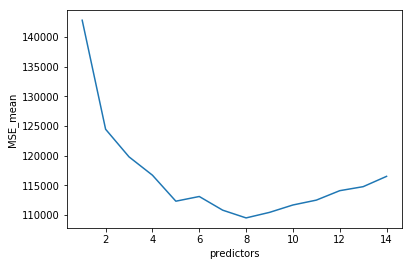

In [22]:
# Perform cross validation for each subset of predictors
results = []
for sub in best_subsets_full:
    results += [cross_val(sub[0], X, y, 10)]

results_a_df = pd.DataFrame({'predictors': list(np.arange(1, 15)),
                           'MSE_mean': [np.mean(i[0]) for i in results],
                           'MSE_folds': [i[0] for i in results],
                           'Model': [i[1] for i in results]})
display(results_a_df)
sns.lineplot(x='predictors', y='MSE_mean', data=results_a_df);

In [23]:
best_subset_choice = results_a_df[results_a_df['MSE_mean'] == results_a_df['MSE_mean'].min()]
display(best_subset_choice)

best_subset_choice['Model'].iloc[0]

,predictors,MSE_mean,MSE_folds,Model
7,8,109522.011671,"[86417.0694422955, 30716.914843531533, 165276....",Salary ~ AtBat + Hits + Walks + CAtBat + CRuns...


'Salary ~ AtBat + Hits + Walks + CAtBat + CRuns + CRBI + CWalks + PutOuts'

We see that 10-fold cross validation selects an 8 variable model. The estimated test MSE is 109,522.

**Revision note:** The ISL authors (p.250) land on an 11 variable model with a higher average MSE of 125,154. Why is this?



### Can we get a better model by Backwards Stepwise on all features?

,rss,predictors,predictor_count
0,2.420070e+07,"[AtBat, Hits, HmRun, Runs, RBI, Walks, Years, ...",1
1,2.420070e+07,"[AtBat, Hits, HmRun, Runs, RBI, Walks, Years, ...",2
2,2.420070e+07,"[AtBat, Hits, HmRun, Runs, RBI, Walks, Years, ...",3
3,2.420070e+07,"[AtBat, Hits, HmRun, Runs, RBI, Walks, Years, ...",4
4,2.420184e+07,"[AtBat, Hits, HmRun, Runs, RBI, Walks, Years, ...",5
5,2.420945e+07,"[AtBat, Hits, HmRun, Runs, RBI, Walks, CAtBat,...",6
6,2.421938e+07,"[AtBat, Hits, HmRun, Runs, RBI, Walks, CAtBat,...",7
7,2.423518e+07,"[AtBat, Hits, HmRun, Runs, Walks, CAtBat, CHit...",8
8,2.424866e+07,"[AtBat, Hits, HmRun, Runs, Walks, CAtBat, CRun...",9
9,2.428915e+07,"[AtBat, Hits, Runs, Walks, CAtBat, CRuns, CRBI...",10


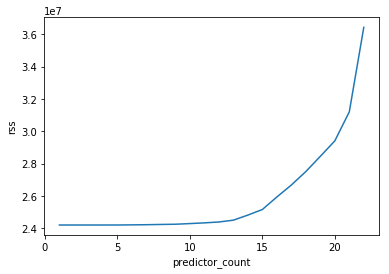

In [24]:
X = hitters_pd.drop('Salary', axis=1)
y = hitters_pd['Salary']

backward_stepwise_subsets = backward_stepwise(X, y)
backward_stepwise_subsets['predictor_count'] = np.arange(1, 23)
display(backward_stepwise_subsets)

sns.lineplot(x='predictor_count', y='rss', data=backward_stepwise_subsets);

,predictors,MSE_mean,MSE_folds,Model
0,1,116599.013674,"[109666.77700982487, 37953.39175638854, 156572...",Salary ~ AtBat + Hits + HmRun + Runs + RBI + W...
1,2,116599.013674,"[109666.7770098258, 37953.39175638837, 156572....",Salary ~ AtBat + Hits + HmRun + Runs + RBI + W...
2,3,116599.013674,"[109666.77700982455, 37953.39175638841, 156572...",Salary ~ AtBat + Hits + HmRun + Runs + RBI + W...
3,4,116599.013674,"[109666.77700982522, 37953.39175638851, 156572...",Salary ~ AtBat + Hits + HmRun + Runs + RBI + W...
4,5,114963.338465,"[108403.40077544513, 36671.65478063551, 156237...",Salary ~ AtBat + Hits + HmRun + Runs + RBI + W...
5,6,113635.830694,"[103548.9789642152, 34980.6193407436, 156343.0...",Salary ~ AtBat + Hits + HmRun + Runs + RBI + W...
6,7,112921.381689,"[103109.24440272473, 35032.07078000676, 155352...",Salary ~ AtBat + Hits + HmRun + Runs + RBI + W...
7,8,111081.510651,"[103134.03455700394, 35026.977780520996, 15560...",Salary ~ AtBat + Hits + HmRun + Runs + Walks +...
8,9,110333.364753,"[98326.25400454745, 35152.30612149243, 155838....",Salary ~ AtBat + Hits + HmRun + Runs + Walks +...
9,10,109979.410931,"[95894.57297758816, 35826.8320322134, 155992.7...",Salary ~ AtBat + Hits + Runs + Walks + CAtBat ...


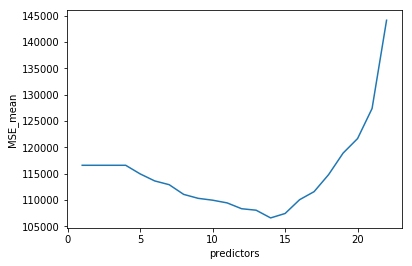

In [25]:
# Perform cross validation for each subset of predictors
results = []
for preds in backward_stepwise_subsets['predictors']:
    f = 'Salary ~ {}'.format(' + '.join(preds))
    results += [cross_val(f, X, y, 10)]

results_b_df = pd.DataFrame({'predictors': list(np.arange(1, len(results)+1)),
                           'MSE_mean': [np.mean(i[0]) for i in results],
                           'MSE_folds': [i[0] for i in results],
                           'Model': [i[1] for i in results]})
display(results_b_df)
sns.lineplot(x='predictors', y='MSE_mean', data=results_b_df);

In [26]:
display(HTML('</br><h4>Best Subset Selection from 14 predictors, with 10-fold Cross Validation</h4>'))
best_subset_choice = results_a_df[results_a_df['MSE_mean'] == results_a_df['MSE_mean'].min()]
display(best_subset_choice)
print(best_subset_choice['Model'].iloc[0])

display(HTML('</br><h4>Backward Stepwise Selection from all 22 predictors, with 10-fold Cross Validation</h4>'))
backward_select_choice = results_b_df[results_b_df['MSE_mean'] == results_b_df['MSE_mean'].min()]
display(backward_select_choice)
print(backward_select_choice['Model'].iloc[0])

,predictors,MSE_mean,MSE_folds,Model
7,8,109522.011671,"[86417.0694422955, 30716.914843531533, 165276....",Salary ~ AtBat + Hits + Walks + CAtBat + CRuns...


Salary ~ AtBat + Hits + Walks + CAtBat + CRuns + CRBI + CWalks + PutOuts


,predictors,MSE_mean,MSE_folds,Model
13,14,106618.881999,"[94639.91163274275, 40255.25372375629, 160138....",Salary ~ AtBat + Hits + Walks + CAtBat + CRuns...


Salary ~ AtBat + Hits + Walks + CAtBat + CRuns + CRBI + CWalks + PutOuts + Division_W


Abov we used backward stepwise selection to make it computationally feasible (on my laptop) to select from all 22 features. 

We see that 10-fold cross validation selects a 14 variable model. The estimated test MSE is 106,618. This represents an improvement on the lowest esitmate MSe achived for best subset selection from 14 features which was 109,522.

Note that Backward Stepwise Selection found the same model, but gained an improved MSE by adding one additional predictor, 'Division_W', which wasn't available to best subset selection due to the constraints of the available compute. 

## Lab 2: Ridge Regression and the Lasso

### 6.6.1 Ridge Regression

Let's perform ridge regression with 10-fold cross-validation to produce results comparable to those obtained for model selection approaches aboce.

In [27]:
def ridge_cv(X, y, λ, k):
    """Perform ridge regresion with 
    k-fold cross validation to return mean MSE scores for each fold"""
    # Split dataset into k-folds
    # Note: np.array_split doesn't raise excpetion is folds are unequal in size
    X_folds = np.array_split(X, k)
    y_folds = np.array_split(y, k)
    
    MSEs = []
    for f in np.arange(len(X_folds)):
        # Create training and test sets
        X_test  = X_folds[f]
        y_test  = y_folds[f]
        X_train = X.drop(X_folds[f].index)
        y_train = y.drop(y_folds[f].index)
        
        # Fit model
        model = linear_model.Ridge(alpha=λ, fit_intercept=False, solver='cholesky').fit(X_train, y_train)
        
        # Measure MSE
        y_hat = model.predict(X_test)
        MSEs += [mse(y_hat, y_test)]
    return MSEs

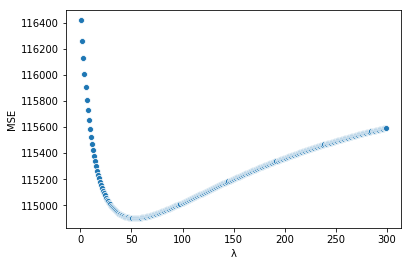

In [30]:
X = hitters_pd.drop('Salary', axis=1)
y = hitters_pd['Salary']

#lambdas = np.arange(0, 0.08, 0.0005)
lambdas = np.arange(1, 300, 1)
MSEs    = [] 
for l in lambdas:
    MSEs += [np.mean(ridge_cv(X, y, λ=l, k=10))]

sns.scatterplot(x='λ', y='MSE', data=pd.DataFrame({'λ': lambdas, 'MSE': MSEs}));

In [31]:
min(zip(MSEs, lambdas))

(114903.19824046272, 53)

Here we use 10-fold cross-validation to find the optimal value for lambda. The lowest MSE score achieved is 114,903 when λ=53.

**Revision note:** This result is worst than our results for backward stepwise selection (106,618) and best subset (109,522), and not as good as that reported by ISL authors (96,016) on p.254.

A very small improvement was observed by setting fit_intercept and normalize to True - in which case the optimal values of lambda became significantly smaller.

(array([-40., -30., -20., -10.,   0.,  10.,  20.,  30.,  40.,  50.,  60.]),
 <a list of 11 Text xticklabel objects>)

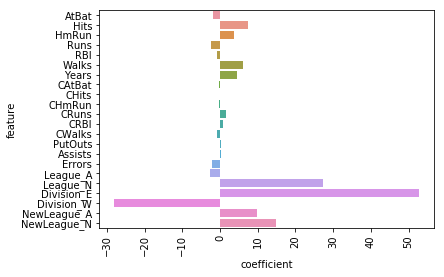

In [32]:
# What coefficients does ridge regression choose for the optimal lambda value?
model = linear_model.Ridge(alpha=53, fit_intercept=False, solver='cholesky').fit(X, y)
df = pd.DataFrame({'feature': X.columns, 'coefficient': model.coef_})
ax = sns.barplot(x='coefficient', y='feature', data=df);
plt.xticks(rotation=90)

### 6.6.2 The Lasso

In [33]:
def lasso_cv(X, y, λ, k):
    """Perform the lasso with 
    k-fold cross validation to return mean MSE scores for each fold"""
    # Split dataset into k-folds
    # Note: np.array_split doesn't raise excpetion is folds are unequal in size
    X_folds = np.array_split(X, k)
    y_folds = np.array_split(y, k)
    
    MSEs = []
    for f in np.arange(len(X_folds)):
        # Create training and test sets
        X_test  = X_folds[f]
        y_test  = y_folds[f]
        X_train = X.drop(X_folds[f].index)
        y_train = y.drop(y_folds[f].index)
        
        # Fit model
        model = linear_model.Lasso(alpha=λ, copy_X=True, fit_intercept=False, max_iter=10000,
                                   normalize=False, positive=False, precompute=False, random_state=None,
                                   selection='cyclic', tol=0.0001, warm_start=False).fit(X_train, y_train)
        
        # Measure MSE
        y_hat = model.predict(X_test)
        MSEs += [mse(y_hat, y_test)]
    return MSEs

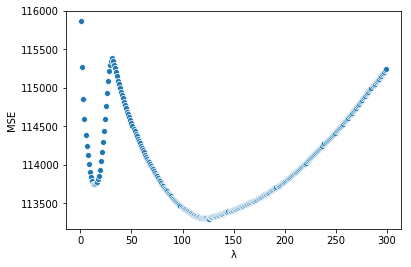

In [34]:
X = hitters_pd.drop('Salary', axis=1)
y = hitters_pd['Salary']

lambdas = np.arange(1, 300, 1)
MSEs    = [] 
for l in lambdas:
    MSEs += [np.mean(lasso_cv(X, y, λ=l, k=10))]

sns.scatterplot(x='λ', y='MSE', data=pd.DataFrame({'λ': lambdas, 'MSE': MSEs}));

In [35]:
min(zip(MSEs, lambdas))

(113299.42601088567, 126)

Here we use 10-fold cross-validation to find the optimal lambda value for the lasso. The lowest MSE score achieved is 113,299 when λ=126.

**Revision note:** This result is marginally better than the result for ridge regression (114,903) which is suprising because the ISL authors observed the opposite.

(array([-2., -1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.]),
 <a list of 9 Text xticklabel objects>)

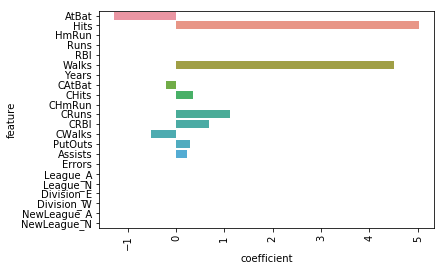

In [36]:
# What coefficients does the lasso choose for the optimal lambda value?
model = linear_model.Lasso(alpha=126, copy_X=True, fit_intercept=False, max_iter=10000,
                           normalize=False, positive=False, precompute=False, random_state=None,
                           selection='cyclic', tol=0.0001, warm_start=False).fit(X, y)
df = pd.DataFrame({'feature': X.columns, 'coefficient': model.coef_})
ax = sns.barplot(x='coefficient', y='feature', data=df);
plt.xticks(rotation=90)

Lasso makes quite different feature choices to ridge regression, completeley ignoring the dummy variables.

In [37]:
display(HTML('<h4>Model chosen by lasso:</h4>'))
print('Salary ~ {}'.format(' + '.join(X.columns[model.coef_ != 0])))
print('MSE: {:01.0f}'.format(min(MSEs)))

display(HTML('<h4>Model chosen by backward stepwise selection:</h4>'))
print(backward_select_choice['Model'].iloc[0])
print('MSE: {:01.0f}'.format(backward_select_choice['MSE_mean'].iloc[0]))

Salary ~ AtBat + Hits + Walks + CAtBat + CHits + CRuns + CRBI + CWalks + PutOuts + Assists
MSE: 113299


Salary ~ AtBat + Hits + Walks + CAtBat + CRuns + CRBI + CWalks + PutOuts + Division_W
MSE: 106619


The results here suggesat that backward stepwise finds as simpler model tha toutperforms lasso and ridge regression. 

**Revision note:** This is contrary to ISL authors results so needs checking.

## Lab 3: PCR and PLS Regression

### 6.7.1 Principle Components Regression

In [44]:
# Deps for pca/pcr
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

In [43]:
# Load data
X = hitters_pd.drop('Salary', axis=1)
y = hitters_pd['Salary']

#### PCA

What percentage of total variance in our dataset is ecplained by succesive accumulation of principal components?

Get all principal components of the predictors in X, using principal component analysis (PCA)

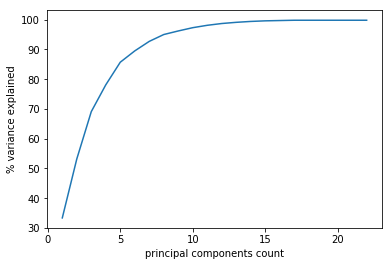

In [149]:
# Get principle components
pca = PCA()
X_reduced = pca.fit_transform(scale(X))

# What variance (%c umulative) is explained by principle components?
variance_explained   = np.cumsum(np.around(pca.explained_variance_ratio_ *100, decimals=1))
principal_components = np.arange(1, len(variance_explained)+1)

sns.lineplot(x='principal components count', y='% variance explained', 
             data=pd.DataFrame({'principal components count': principal_components, 
                                '% variance explained': variance_explained}));

In [148]:
X_reduced = pca.fit_transform(scale(X))
X_reduced.shape

(263, 22)

#### PCR 

How does linear regression perform when these principle components are used as predictors?

In [181]:
def pcr_cv(seed, cv_folds):
    """Perform Principle Component Regression evaluated with
    k-fold cross validation"""
    # Load data
    X = hitters_pd.drop('Salary', axis=1)
    y = hitters_pd['Salary']
    
    # Get all principle components
    pca = PCA()
    X_reduced = pca.fit_transform(scale(X))
    
    # Get cv MSE for cumulative components
    M = X_reduced.shape[1]
    MSEs = []
    for m in range(M):
        model = LinearRegression()
        cv    = KFold(n_splits=cv_folds, random_state=seed, shuffle=True)
        cv10  = cross_val_score(model, X_reduced[:, 0:m+1], y, cv=cv, scoring='neg_mean_squared_error')
        MSEs += [np.mean(np.abs(cv10))]
        
    ax = sns.lineplot(x='principal components count', y='MSE', 
                 data=pd.DataFrame({'principal components count': principal_components, 
                                    'MSE': MSEs}));
    ax.axes.set_ylim(100000, 140000)


interact(pcr_cv, 
         seed=widgets.IntSlider(min=1, max=50, step=1, value=10), 
         cv_folds=widgets.IntSlider(min=2, max=100, step=1, value=10));

interactive(children=(IntSlider(value=10, description='seed', max=50, min=1), IntSlider(value=10, description=…

The ISL authors report a minimum MSE when the number of principle componenents M = 16.  

Above I've implemented the same with interactive sliders to control the random seed used to shuffle observations before splitting into cross validation folds, and a seperate control for number of cross validation folds k. 

Interacting with the seed slider we see that there is some significant variability in the results. With 10 folds, most seed values would lead us to conclude the between 16-18 principal components are optimal, but there are some seed values – such as 8 – that suggest 6-7 components is in fact optimal. This is a significantly different conclusion!

The results seem to have higher variance when cv_folds is lower, with variance decreasing as the number of folds increases.

**Revision note:** The above point seems counter to what we learned in ch.5, e.g. we expect LOOCV to exhibit highest variance and lowest bias.

In [152]:
def pcr_holdout(seed):
    """Perform Principle Component Regression evaluated with
    k-fold hold-out set"""
    # With 50% holdout set
    np.random.seed(seed)
    train = np.random.rand(len(hitters_pd)) < 0.5
    
    pca = PCA()
    X_train = pca.fit_transform(scale(hitters_pd.drop('Salary', axis=1)[train]))
    y_train = hitters_pd['Salary'][train]
    X_test  = pca.fit_transform(scale(hitters_pd.drop('Salary', axis=1)[~train]))
    y_test  = hitters_pd['Salary'][~train]
    
    MSEs = []
    for m in range(M):
        model = LinearRegression().fit(X_train[:, 0:m+1], y_train)
        y_hat = model.predict(X_test[:, 0:m+1])
        MSEs += [mse(y_hat, y_test)]
    
    # Plot results
    ax = sns.lineplot(x='principal components count', y='MSE', 
                      data=pd.DataFrame({'principal components count': principal_components, 
                                         'MSE': MSEs}))
    ax.axes.set_ylim(50000, 200000);

interact(pcr_holdout, seed=widgets.IntSlider(min=1, max=50, step=1, value=10));

interactive(children=(IntSlider(value=10, description='seed', max=50, min=1), Output()), _dom_classes=('widget…

The ISL authors report an 50% hold-out MSE of 96556 when M=7. This seems low in comparison to the initial result we observe above, with a random seed of 10 we see min MSE of about 140000 with M=1. 

Interacting with the seed slider we can find results comparable to those reported by the authors – for example when the seed = 3 a minimum MSE of about 85000 is observed for M=7. 

This outlines the importance of understanding the variance in results due to training/test set sampling, before making any comparisons.

For example previously I concluded that backward stepwise selection yielded the lowest MSE, whereas the ISL found ridge regression most effective. It seems that either of these observations could be correct, or both wrong, given the unquantified variance in results due to cross validation sampling.

Possible mitigations:

1. Ensure that identical observation samples are used in each fold when comparing techniques. This approach is limited because a certain approach might just happen to perform particularly well with the chosen samples.
2. Measure the probabilistic distribution of results for each approach and compare. This allows you to quantify the confidence of any conclusions.

**Revision notes:** discuss

#### PLS

In [182]:
from sklearn.cross_decomposition import PLSRegression

def pls_cv(seed, cv_folds):
    """Perform Partial Least Squares Regression evaluated with
    k-fold cross validation"""
    # Load data
    X = hitters_pd.drop('Salary', axis=1)
    y = hitters_pd['Salary']
    
    # Get cv MSE for cumulative components
    M = X.shape[1]
    MSEs = []
    for m in range(M):
        cv      = KFold(n_splits=cv_folds, random_state=seed, shuffle=True)
        results = cross_val_score(PLSRegression(n_components=m+1, scale=True, max_iter=10), 
                                  X, y, cv=cv, scoring='neg_mean_squared_error')
        MSEs   += [np.mean(np.abs(results))]
        
    ax = sns.lineplot(x='principal components count', y='MSE', 
                 data=pd.DataFrame({'principal components count': principal_components, 
                                    'MSE': MSEs}));
    ax.axes.set_ylim(100000, 140000)


interact(pls_cv, 
         seed=widgets.IntSlider(min=1, max=50, step=1, value=10), 
         cv_folds=widgets.IntSlider(min=2, max=100, step=1, value=10));

interactive(children=(IntSlider(value=10, description='seed', max=50, min=1), IntSlider(value=10, description=…

PLS seems to perform similarly to PCR with fewer predictors, although we cannot be conclusive due to variance in our cv.